In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from functools import partial

First let's process the data.

In [82]:
# An array to store the rows of data.
rows = []

In [83]:
with open('glass.dat') as f:
    for line in f:
        row = line.split()
        rows.append(row)

In [84]:
# The rows containing data (not names of columns).
data_rows = rows[1:]
data_rows = [row[1:] for row in data_rows]

In [85]:
# Column names.
cols = rows[0]

In [86]:
df = pd.DataFrame.from_records(data_rows)
df.columns = cols

for col in ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']:
    df[col] = df[col].astype('float')

In [87]:
X = df['Al'].to_numpy()

In [88]:
Y = df['RI'].to_numpy()

To do the non-parametric regression we need to order $X$ and $Y$.

In [89]:
order = np.argsort(X)

In [90]:
X = X[order]
Y = Y[order]

Here's a scatterplot of the data.

Text(0, 0.5, 'Refractive index')

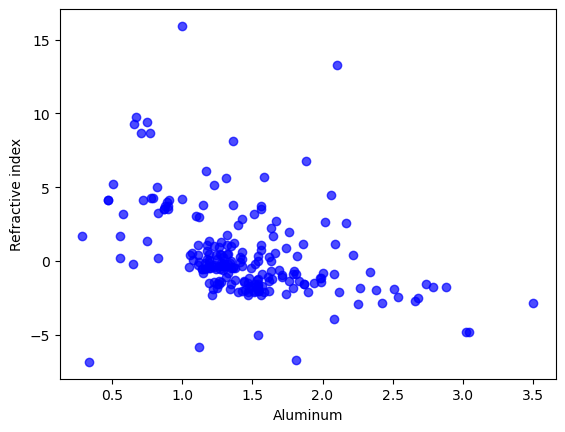

In [91]:
plt.scatter(X, Y, c='blue', alpha=0.7)
plt.xlabel('Aluminum')
plt.ylabel('Refractive index')

In [92]:
# Lower and upper bounds on the x-values in our dataset
lower, upper = 0, 4
ran = upper - lower

In [93]:
# A Gaussian kernel
K = norm.pdf

In [94]:
def r(x,h):
    """The Nadaraya-Watson kernel estimator with bandwidth h"""
    ker_vals = K((x - X) / h)
    total = ker_vals.sum()
    return np.dot(ker_vals, Y) / total

Here are pictures of the Nadaraya-Watson estimators with different bandwidths h.

/var/folders/h9/7qb3ygvs0mzb0cdjbh8z8svr0000gn/T/ipykernel_54548/775219246.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(ker_vals, Y) / total


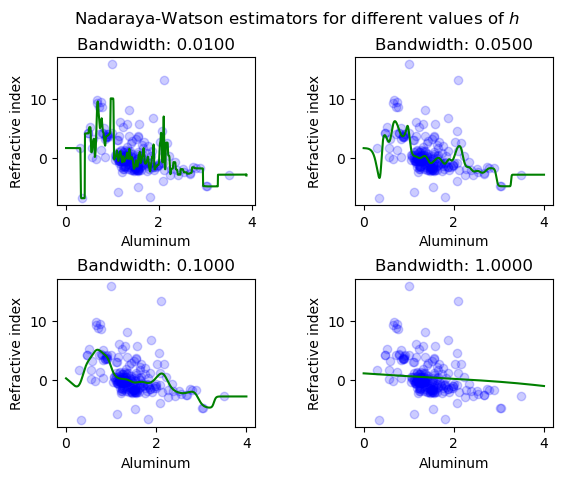

In [95]:
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle(f'Nadaraya-Watson estimators for different values of $h$')

x = np.linspace(lower, upper, 10000)
for i,bandwidth in enumerate([0.01, 0.05, 0.1, 1]):
    ax = axs[i // 2][i % 2]
    f = partial(r, h=bandwidth)
    y = list(map(f, x))
    ax.plot(x, y, c='green', alpha=1)
    ax.scatter(X, Y, c='blue', alpha=0.2)
    ax.set_xlabel('Aluminum')
    ax.set_ylabel('Refractive index')
    ax.set_title(f'Bandwidth: {bandwidth:.4f}')

Now we'll find the optimal risk using Theorem 20.22.

In [96]:
risks = []

In [97]:
num_widths = 1000

In [98]:
bandwidths = np.linspace(0.0001, 2, num=num_widths)

In [99]:
diff_matrix = X - X.reshape(-1,1)

In [100]:
for i,h in enumerate(bandwidths):
    output = np.array(list(map(partial(r,h=h), X)))
    
    # The first factor inside the sum in equation 20.35
    factor1 = (Y - output)**2
    
    # The second factor inside the sum in equation 20.35
    denom = K(diff_matrix / h).sum(axis=0)
    factor2 = (1 / (1 - (K(0) / denom)))**2
    
    risk = np.dot(factor1, factor2)
    risks.append(risk)

/var/folders/h9/7qb3ygvs0mzb0cdjbh8z8svr0000gn/T/ipykernel_54548/453269110.py:9: RuntimeWarning: divide by zero encountered in divide
  factor2 = (1 / (1 - (K(0) / denom)))**2


Text(0.5, 1.0, 'Cross validation score versus bandwidth')

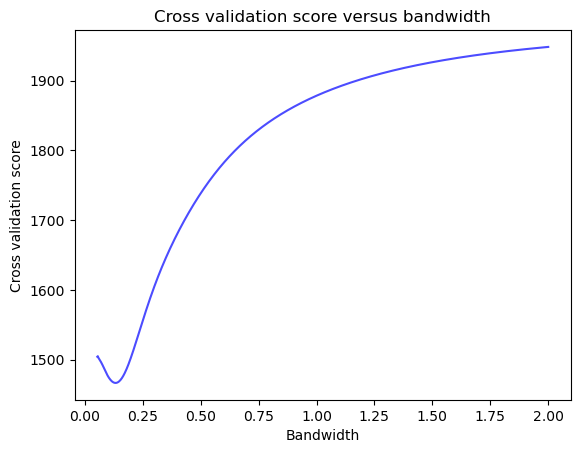

In [101]:
plt.plot(bandwidths, risks, c='blue', alpha=0.7)
plt.xlabel('Bandwidth')
plt.ylabel('Cross validation score')
plt.title('Cross validation score versus bandwidth')

In [102]:
best_bandwidth = bandwidths[np.nanargmin(risks)]

In [103]:
print(f'Bandwidth with least estimated risk: {best_bandwidth:.4f}')

Bandwidth with least estimated risk: 0.1322


In [104]:
def w(x):
    """The weights w for the estimated best bandwidth"""
    terms = K((x - X) / best_bandwidth)
    return terms / terms.sum()

In [105]:
n = len(X)

In [106]:
# The estimate for sigma^2 in equation 20.36
sigma2 = 1 / (2 * (n - 1)) * ((np.roll(Y, -1) - Y)[:-1]**2).sum()

In [107]:
# The estimated standard error in equation 20.37
se = lambda x: np.sqrt(sigma2 * (w(x)**2).sum())

In [108]:
m = ran / omega

In [109]:
alpha = 0.05

In [110]:
q = norm.ppf((1 + (1 - alpha)**(1/m)) / 2)

In [111]:
# The Naraya-Watson estimator for the best bandwidth
R = partial(r, h=best_bandwidth)

In [112]:
# The lower bound for the confidence band
L = lambda x: R(x) - q*se(x)

In [113]:
# The upper bound for the confidence band
U = lambda x: R(x) + q*se(x)

In [114]:
x = np.linspace(lower, upper, 5000)

In [115]:
r = list(map(R, x))

In [116]:
l = list(map(L, x))

In [117]:
u = list(map(U, x))

Here's a plot of our 95% confidence band, with our estimator colored in red.

Text(0, 0.5, 'Refractive index')

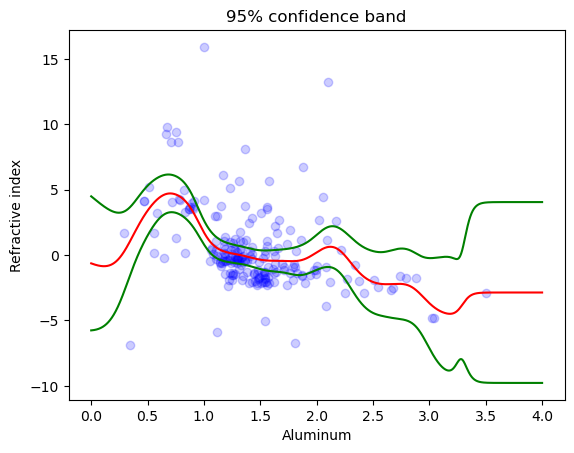

In [121]:
plt.plot(x, l, c='green', alpha=1)
plt.plot(x, u, c='green', alpha=1)
plt.plot(x, r, c='red', alpha=1)
plt.scatter(X, Y, c='blue', alpha=0.2)
plt.title('95% confidence band')
plt.xlabel('Aluminum')
plt.ylabel('Refractive index')